Title: Reproduction of Spatial Accessibility of COVID-19 Healthcare Resources in Illinois
---

### Reproduction

**Reproduction of**: Rapidly measuring spatial accessibility of COVID-19 healthcare resources: a case study of Illinois, USA

Original study *by* Kang, J. Y., A. Michels, F. Lyu, Shaohua Wang, N. Agbodo, V. L. Freeman, and Shaowen Wang. 2020. Rapidly measuring spatial accessibility of COVID-19 healthcare resources: a case study of Illinois, USA. International Journal of Health Geographics 19 (1):1–17. DOI:[10.1186/s12942-020-00229-x](https://ij-healthgeographics.biomedcentral.com/articles/10.1186/s12942-020-00229-x).

Reproduction Authors: Joe Holler, Kufre Udoh, Derrick Burt, Drew An-Pham, & Spring '21 Middlebury Geog 0323.

Reproduction Materials Available at: [github.com/HEGSRR/RPr-Kang-2020](https://github.com/HEGSRR/RPr-Kang-2020)

Created: `8 Jun 2021`
Revised: `26 Feb 2023`


## Computational Environment
The original study was conducted using an undocumented version of Python on the University of Illinois Urbana Champaign CyberGISX server.
The current version of the study is designed to run on the CyberGISX Python 3 environment using Python version 3.8.12.
See `environment.yml` for more details on the library versions.
Key packages include the following:

In [1]:
# report python version and install required packages
# switch if statement from False to True to install packages with Conda
if False:
    !python -V
    !conda install -c conda-forge osmnx=1.1.2 -y
    !conda env update --file ../environment/environment.yml -q

In [2]:
# Import modules
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import osmnx as ox
import re
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
import folium
import itertools
import os
import time
import warnings
import requests
from scipy import stats
from IPython.display import display, clear_output

warnings.filterwarnings("ignore")
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.22.0
pandas==1.3.5
geopandas==0.10.2
networkx==2.6.3
osmnx==1.1.2
re==2.2.1
folium==0.12.1.post1
requests==2.27.1


### Set working directory

Set the working directory to the root of the research compendium.

In [3]:
# if the working directory is the 'code' folder, move up two folders to the compendium root
if os.path.basename(os.getcwd()) == 'code':
    # This line moves the directory up two folders 
    os.chdir('../../')
print('The working directory is', os.getcwd())

The working directory is /home/jovyan/work/RPr-Kang-2020


## Data
To perform the ESFCA method, three types of data are required, as follows: (1) road network, (2) population, and (3) hospital information. The road network can be obtained from the [OpenStreetMap Python Library, called OSMNX](https://github.com/gboeing/osmnx). The population data is available on the [American Community Survey](https://data.census.gov/cedsci/deeplinks?url=https%3A%2F%2Ffactfinder.census.gov%2F&tid=GOVSTIMESERIES.CG00ORG01). Lastly, hosptial information is also publically available on the [Homelanad Infrastructure Foundation-Level Data](https://hifld-geoplatform.opendata.arcgis.com/datasets/hospitals?geometry=-94.504%2C40.632%2C-80.980%2C43.486).

### Population and COVID-19 Cases Data by County

In [4]:
# Load data for at risk population
atrisk_data = gpd.read_file('./data/raw/public/PopData/Chicago_Tract.shp')
atrisk_data.head()

,GEOID,STATEFP,COUNTYFP,TRACTCE,NAMELSAD,Pop,Unnamed_ 0,NAME,OverFifty,TotalPop,geometry
0,17031010400,17,031,010400,Census Tract 104,5153,1538,"Census Tract 104, Cook County, Illinois",1103,5153,"POLYGON ((-87.66125 42.01288, -87.66125 42.012..."
1,17031010600,17,031,010600,Census Tract 106,6271,438,"Census Tract 106, Cook County, Illinois",1469,6271,"POLYGON ((-87.67059 42.00537, -87.67046 42.005..."
2,17031030200,17,031,030200,Census Tract 302,5444,2075,"Census Tract 302, Cook County, Illinois",2018,5444,"POLYGON ((-87.67062 41.99808, -87.67045 41.998..."
3,17031030300,17,031,030300,Census Tract 303,3464,516,"Census Tract 303, Cook County, Illinois",1097,3464,"POLYGON ((-87.67501 41.99799, -87.67473 41.998..."
4,17031030400,17,031,030400,Census Tract 304,2582,1520,"Census Tract 304, Cook County, Illinois",860,2582,"POLYGON ((-87.67471 41.99076, -87.67440 41.990..."


In [5]:
# Load data for covid cases
covid_data = gpd.read_file('./data/raw/public/PopData/Chicago_ZIPCODE.shp')
covid_data['cases'] = covid_data['cases']
covid_data.head()

,ZCTA5CE10,County,State,Join,ZONE,ZONENAME,FIPS,pop,cases,geometry
0,60660,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,43242,78,"POLYGON ((-87.65049 41.99735, -87.65029 41.996..."
1,60640,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,69715,117,"POLYGON ((-87.64645 41.97965, -87.64565 41.978..."
2,60614,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,71308,134,"MULTIPOLYGON (((-87.67703 41.91845, -87.67705 ..."
3,60712,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,12539,42,"MULTIPOLYGON (((-87.76181 42.00465, -87.76156 ..."
4,60076,Cook County,IL,Cook County IL,IL_E,Illinois East,1201,31867,114,"MULTIPOLYGON (((-87.74782 42.01540, -87.74526 ..."


### Hospital Data

Note that 999 is treated as a "NULL"/"NA" so these hospitals are filtered out. This data contains the number of ICU beds and ventilators at each hospital.

In [6]:
# Load data for hospitals
hospitals = gpd.read_file('./data/raw/public/HospitalData/Chicago_Hospital_Info.shp')
hospitals.head()

,FID,Hospital,City,ZIP_Code,X,Y,Total_Bed,Adult ICU,Total Vent,geometry
0,2,Methodist Hospital of Chicago,Chicago,60640,-87.671079,41.972800,145,36,12,MULTIPOINT (-87.67108 41.97280)
1,4,Advocate Christ Medical Center,Oak Lawn,60453,-87.732483,41.720281,785,196,64,MULTIPOINT (-87.73248 41.72028)
2,13,Evanston Hospital,Evanston,60201,-87.683288,42.065393,354,89,29,MULTIPOINT (-87.68329 42.06539)
3,24,AMITA Health Adventist Medical Center Hinsdale,Hinsdale,60521,-87.920116,41.805613,261,65,21,MULTIPOINT (-87.92012 41.80561)
4,25,Holy Cross Hospital,Chicago,60629,-87.690841,41.770001,264,66,21,MULTIPOINT (-87.69084 41.77000)


### Generate and Plot Map of Hospitals

In [7]:
# Plot hospitals
m = folium.Map(location=[41.85, -87.65], tiles='cartodbpositron', zoom_start=10)

for i in range(0, len(hospitals)):
    folium.CircleMarker(
      location=[hospitals.iloc[i]['Y'], hospitals.iloc[i]['X']],
      popup="{}{}\n{}{}\n{}{}".format('Hospital Name: ',hospitals.iloc[i]['Hospital'],
                                      'ICU Beds: ',hospitals.iloc[i]['Adult ICU'],
                                      'Ventilators: ', hospitals.iloc[i]['Total Vent']),
      radius=5,
      color='grey',
      fill=True,
      fill_opacity=0.6,
      legend_name = 'Hospitals'
    ).add_to(m)
legend_html =   '''<div style="position: fixed; width: 20%; heigh: auto;
                            bottom: 10px; left: 10px;
                            solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; Legend<br>'''

m

### Load and Plot Hexagon Grid (500-meter resolution)

<AxesSubplot:>

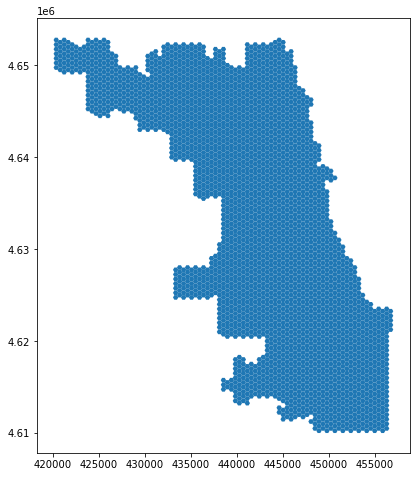

In [8]:
# Load grid file and plot
grid_file = gpd.read_file('./data/raw/public/GridFile/Chicago_Grid.shp')
grid_file = grid_file.drop(columns=["left","right","top","bottom"])
grid_file.plot(figsize=(8,8))

### Load Street Network

Load a street network for either the extent of Chicago, Illinois (provided with the original research compendium) or for the extent of Chicago, Illinois expanded with a buffer distance of 15 miles (24140.2 meters).

In [9]:
%%time
# set buffered to True to use a street network expanded 15 miles beyond Chicago
# rather than a network limited to Chicago itself
buffered = False

# set OSM to True and delete or rename any data/raw/private/Chicago_Network_Buffer.graphml file to create a new graph from OpenStreetMap
# rather than downloading a graph from this project's OSF.io file
OSM = False

# if not using a buffered street network, load the original graph for the study
if not buffered:
    print("Loading original Chicago road network from data/raw/public/Chicago_Network.graphml. Please wait...", flush=True)
    G = ox.load_graphml('./data/raw/public/Chicago_Network.graphml') 
    print("Data loaded.")

# if using a buffered street network and the buffered street network is already saved, load it
elif os.path.exists("./data/raw/private/Chicago_Network_Buffer.graphml"):
    print("Loading buffered Chicago road network from raw/private/Chicago_Network_Buffer.graphml. Please wait...", flush=True)
    G = ox.load_graphml('./data/raw/private/Chicago_Network_Buffer.graphml') 
    print("Data loaded.") 

# if using a buffered street network, buffered street network is not saved, and OSM is preferred,
# generate a new graph from OpenStreetMap and save it
elif OSM:
    print("Loading buffered Chicago road network from OpenStreetMap. Please wait... runtime may exceed 9min...", flush=True)
    G = ox.graph_from_place('Chicago', network_type='drive', buffer_dist=24140.2) 
    print("Saving Chicago road network to raw/private/Chicago_Network_Buffer.graphml. Please wait...", flush=True)
    ox.save_graphml(G, './data/raw/private/Chicago_Network_Buffer.graphml')
    print("Data saved.")

# otherwise, a buffered network is preferred and can be downloaded from the OSF project
else:
    print("Downloading buffered Chicago road network from OSF...", flush=True)
    url = 'https://osf.io/download/z8ery/'
    r = requests.get(url, allow_redirects=True)
    print("Saving buffered Chicago road network to file...", flush=True)
    open('./data/raw/private/Chicago_Network_Buffer.graphml', 'wb').write(r.content)
    print("Loading buffered Chicago road network from raw/private/Chicago_Network_Buffer.graphml. Please wait...", flush=True)
    G = ox.load_graphml('./data/raw/private/Chicago_Network_Buffer.graphml') 
    print("Data loaded.") 

Loading original Chicago road network from data/raw/public/Chicago_Network.graphml. Please wait...
Data loaded.
CPU times: user 9.67 s, sys: 336 ms, total: 10 s
Wall time: 9.98 s


In [10]:
#%%time
#buffered = True
# change buffered to True to load an expanded (buffered) street network

#if not buffered:
#    print("Loading original unbuffered Chicago road network from data/raw/public/Chicago_Network.graphml. Please wait...", flush=True)
#    G = ox.load_graphml('./data/raw/public/Chicago_Network.graphml') 
#    print("Data loaded.")

#elif os.path.exists("./data/raw/private/Chicago_Network_Buffer.graphml"):
#    print("Loading buffered Chicago road network from raw/private/Chicago_Network_Buffer.graphml. Please wait...", flush=True)
#    G = ox.load_graphml('./data/raw/private/Chicago_Network_Buffer.graphml') 
#    print("Data loaded.")    
    
#else:
#    print("Loading buffered Chicago road network from OpenStreetMap. Please wait... runtime may exceed 9min...", flush=True)
#    G = ox.graph_from_place('Chicago', network_type='drive', buffer_dist=24140.2) 
#    print("Saving Chicago road network to raw/private/Chicago_Network_Buffer.graphml. Please wait...", flush=True)
#    ox.save_graphml(G, './data/raw/private/Chicago_Network_Buffer.graphml')
#    print("Data saved.")

Loading buffered Chicago road network from OpenStreetMap. Please wait... runtime may exceed 9min...
Saving Chicago road network to raw/private/Chicago_Network_Buffer.graphml. Please wait...
Data saved.
CPU times: user 7min 10s, sys: 6.64 s, total: 7min 16s
Wall time: 11min 30s


### Plot the Road Network

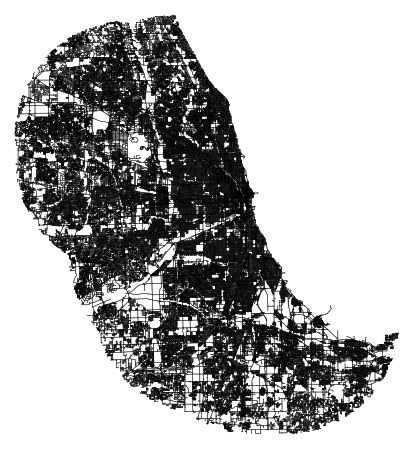

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [11]:
# %%time
ox.plot_graph(G, node_size = 1, bgcolor = 'white', node_color = 'black', edge_color = "#333333", node_alpha = 0.5, edge_linewidth = 0.5)

## Data Processing

In this section, raw data is processed in preparation for the accessibility analysis. Functions are first defined and then called to process the data.

### network_setting

Cleans the OSMNX network to work better with drive-time analysis.

First, we remove all nodes with 0 outdegree because any hospital assigned to such a node would be unreachable from everywhere. Next, we remove small (under 10 node) *strongly connected components* to reduce erroneously small ego-centric networks. Lastly, we ensure that the max speed is set and in the correct units before calculating time.

Args:

* network: OSMNX network for the spatial extent of interest

Returns:

* OSMNX network: cleaned OSMNX network for the spatial extent

In [12]:
def network_setting(network):
    _nodes_removed = len([n for (n, deg) in network.out_degree() if deg ==0])
    network.remove_nodes_from([n for (n, deg) in network.out_degree() if deg ==0])
    for component in list(nx.strongly_connected_components(network)):
        if len(component)<10:
            for node in component:
                _nodes_removed+=1
                network.remove_node(node)
    for u, v, k, data in tqdm(G.edges(data=True, keys=True),position=0):
        if 'maxspeed' in data.keys():
            speed_type = type(data['maxspeed'])
            if (speed_type==str):
                # Add in try/except blocks to catch maxspeed formats that don't fit Kang et al's cases
                try:
                    if len(data['maxspeed'].split(','))==2:
                        data['maxspeed_fix']=float(data['maxspeed'].split(',')[0])                  
                    elif data['maxspeed']=='signals':
                        data['maxspeed_fix']=35.0 # Drive speed setting as 35 miles
                    else:
                        data['maxspeed_fix']=float(data['maxspeed'].split()[0])
                except:
                    data['maxspeed_fix']=35.0 # Miles
            else:
                try:
                    data['maxspeed_fix']=float(data['maxspeed'][0].split()[0])
                except:
                    data['maxspeed_fix']=35.0 # Miles
        else:
            data['maxspeed_fix']= 35.0 # Miles
        data['maxspeed_meters'] = data['maxspeed_fix']*26.8223 # Convert mile to meter
        data['time'] = float(data['length'])/ data['maxspeed_meters']
    print("Removed {} nodes ({:2.4f}%) from the OSMNX network".format(_nodes_removed, _nodes_removed/float(network.number_of_nodes())))
    print("Number of nodes: {}".format(network.number_of_nodes()))
    print("Number of edges: {}".format(network.number_of_edges()))
    return(network)

#### Pre Process Street network

First, check speed limit attribute data and total number of edges.

In [13]:
%%time
# Turn edges into geodataframe
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

# Get unique counts of road segments for each speed limit
print('Total segments: ', len(edges))
print('No speed data: ', edges['maxspeed'].isna().sum())
print(edges['maxspeed'].value_counts())

Total segments:  384974
No speed data:  358311
25 mph                        6016
30 mph                        4873
35 mph                        4803
20 mph                        3621
40 mph                        2842
45 mph                        2423
55 mph                         876
60 mph                         293
50 mph                         287
15 mph                         107
70 mph                          79
[45 mph, 40 mph]                54
10 mph                          44
65 mph                          36
[35 mph, 40 mph]                36
[35 mph, 30 mph]                36
[35 mph, 45 mph]                34
[45 mph, 55 mph]                29
45,30                           24
[45 mph, 50 mph]                19
25, east                        14
25                              14
[40 mph, 30 mph]                11
[30 mph, 25 mph]                 7
[35 mph, 20 mph]                 6
[35 mph, 25 mph]                 6
[25 mph, 30 mph]                 6
[60 mph,

Second, use the network_setting function to simplify the network and process speed limit data into driving time.

In [14]:
%%time
# G, hospitals, grid_file, pop_data = file_import (population_dropdown.value, place_dropdown.value)
G = network_setting(G)
# Create point geometries for each node in the graph, to make constructing catchment area polygons easier
for node, data in G.nodes(data=True):
    data['geometry']=Point(data['x'], data['y'])
# Modify code to react to processor dropdown (got rid of file_import function)

100%|██████████| 384591/384591 [00:01<00:00, 212946.85it/s]


Removed 315 nodes (0.0022%) from the OSMNX network
Number of nodes: 142777
Number of edges: 384591
CPU times: user 6.7 s, sys: 286 ms, total: 6.99 s
Wall time: 6.96 s


Third, review speed limit attribute data and total number of edges.

In [15]:
%%time
# Turn edges into geodataframe
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

# Get unique counts of road segments for each speed limit
print('Total segments: ', len(edges))
print('No speed data: ', edges['maxspeed_fix'].isna().sum())
print('Speed\tn')
print(edges['maxspeed_fix'].value_counts())

Total segments:  384591
No speed data:  0
Speed	n
35.0    362899
25.0      6050
30.0      4881
20.0      3627
40.0      2855
45.0      2560
55.0       870
60.0       295
50.0       287
15.0       114
70.0        74
10.0        44
65.0        33
5.0          2
Name: maxspeed_fix, dtype: int64
CPU times: user 39.3 s, sys: 173 ms, total: 39.4 s
Wall time: 39.3 s


### hospital_setting

Finds the nearest OSMNX node for each hospital.

Args:

* hospital: GeoDataFrame of hospitals
* G: OSMNX network

Returns:

* GeoDataFrame of hospitals with info on nearest OSMNX node

In [16]:
def hospital_setting(hospitals, G):
    # Create an empty column 
    hospitals['nearest_osm']=None
    # Append the neaerest osm column with each hospitals neaerest osm node
    for i in tqdm(hospitals.index, desc="Find the nearest osm from hospitals", position=0):
        hospitals['nearest_osm'][i] = ox.get_nearest_node(G, [hospitals['Y'][i], hospitals['X'][i]], method='euclidean') # find the nearest node from hospital location
    print ('hospital setting is done')
    return(hospitals)

### Join Hospitals to Street Network

Use the hospital_setting function to attach hospitals to the nearest street network node

In [17]:
%%time
hospitals = hospital_setting(hospitals, G)

Find the nearest osm from hospitals: 100%|██████████| 66/66 [02:08<00:00,  1.95s/it]

hospital setting is done
CPU times: user 2min 10s, sys: 453 ms, total: 2min 11s
Wall time: 2min 8s


### pop_centroid

Converts polygon data to centroid points. 

Args:

* pop_data: a GeodataFrame
* pop_type: a string, either "pop" for general population or "covid" for COVID-19 case data

Returns:

* GeoDataFrame of centroids with population data

In [18]:
# To estimate the centroids of census tract / county
def pop_centroid (pop_data, pop_type):
    pop_data = pop_data.to_crs({'init': 'epsg:4326'})
    # If pop is selected in dropdown, select at risk pop where population is greater than 0
    if pop_type =="pop":
        pop_data=pop_data[pop_data['OverFifty']>=0] 
    # If covid is selected in dropdown, select where covid cases are greater than 0
    if pop_type =="covid":
        pop_data=pop_data[pop_data['cases']>=0]
    pop_cent = pop_data.centroid # it make the polygon to the point without any other information
    # Convert to gdf
    pop_centroid = gpd.GeoDataFrame()
    i = 0
    message = 'Calculating centroids for ' + pop_type
    for point in tqdm(pop_cent, desc=message, position=0):
        if pop_type== "pop":
            pop = pop_data.iloc[i]['OverFifty']
            code = pop_data.iloc[i]['GEOID']
        if pop_type =="covid":
            pop = pop_data.iloc[i]['cases']
            code = pop_data.iloc[i].ZCTA5CE10
        pop_centroid = pop_centroid.append({'code':code,'pop': pop,'geometry': point}, ignore_index=True)
        i = i+1
    return(pop_centroid)

### Transform Population Data into Points

Use the pop_centroid function to:
1. convert at risk population data from Census Tract polygons into centroid points, and 
2. convert COVID case data from zip code tabulation area polygons into centroid points.

In [19]:
%%time
pop_atrisk = pop_centroid(atrisk_data, "pop")
pop_covid = pop_centroid(covid_data, "covid")

Calculating centroids for covid: 100%|██████████| 86/86 [00:01<00:00, 65.31it/s]

CPU times: user 38.1 s, sys: 1.08 s, total: 39.2 s
Wall time: 39 s


## Analysis

The analysis section implements the enhanced two-step floating catchment area method in three phases. First, functions are defined to manage the computationally intensive analysis in a parallel processing framework. Second, the user may choose between two different populations (at-risk over 50 years, or COVID cases) and two different resource types (ICU beds or ventilators). Third, the functions and user selections are applied to to implement the E2SFCA method.

### calculate_catchment_area

Calculates a catchment area of things within some distance of a point using a given metric.

Function first creates an ego-centric subgraph on the NetworkX road network starting with the nearest OSM node for the hospital and going out to a given distance as measured by the distance unit. We then calculate the convex hull around the nodes in the ego-centric subgraph and make it a GeoPandas object.

Args:

* G: OSMNX network
* nearest_osm: OSMNX road network node that is closest to the place of interest (hospital)
* distance: the max distance to include in the catchment area
* distance_unit: how we measure distance (used by ego_graph), we always use time

Returns:

* GeoDataFrame the catchment area.

In [20]:
def calculate_catchment_area(G, nearest_osm, distance, distance_unit = "time"):
    # Consutrct an ego graph based on distance unit for an input node
    road_network = nx.ego_graph(G, nearest_osm, distance, distance=distance_unit) 
    # Create point geometries for all nodes in ego graph
    nodes = [Point((data['x'], data['y'])) for node, data in road_network.nodes(data=True)]
    # Create a single part geometry of all nodes
    polygon = gpd.GeoSeries(nodes).unary_union.convex_hull ## to create convex hull
    polygon = gpd.GeoDataFrame(gpd.GeoSeries(polygon)) ## change polygon to geopandas
    polygon = polygon.rename(columns={0:'geometry'}).set_geometry('geometry')
    return polygon.copy(deep=True)

### hospital_measure_acc

Measures the effect of a single hospital on the surrounding area. (Uses `calculate_catchment_area` or `djikstra_cca`)

Args:

* \_thread\_id: int used to keep track of which thread this is
* hospital: Geopandas dataframe with information on a hospital
* pop_data: Geopandas dataframe with population data
* distances: Distances in time to calculate accessibility for
* weights: how to weight the different travel distances

Returns:

* Tuple containing:
    * Int (\_thread\_id)
    * GeoDataFrame of catchment areas with key stats

In [21]:
def hospital_measure_acc (_thread_id, hospital, pop_data, distances, weights):
    # Apply catchment calculation for each distance (10, 20, and 30 min)
    polygons = []
    for distance in distances:
        # Append djikstra catchment calculation (uncomment to use)
        polygons.append(calculate_catchment_area(G, hospital['nearest_osm'],distance))
    # Clip the overlapping distance ploygons (create two donuts + hole)
    for i in reversed(range(1, len(distances))):
        polygons[i] = gpd.overlay(polygons[i], polygons[i-1], how="difference")
    
    # Calculate accessibility measurements
    num_pops = []
    for j in pop_data.index:
        point = pop_data['geometry'][j]
        # Multiply polygons by weights
        for k in range(len(polygons)):
            if len(polygons[k]) > 0: # To exclude the weirdo (convex hull is not polygon)
                if (point.within(polygons[k].iloc[0]["geometry"])):
                    num_pops.append(pop_data['pop'][j]*weights[k])  
    total_pop = sum(num_pops)
    for i in range(len(distances)):
        polygons[i]['time']=distances[i]
        polygons[i]['total_pop']=total_pop
        polygons[i]['icu_beds'] = float(hospital['Adult ICU'])/polygons[i]['total_pop'] # proportion of # of beds over pops in 10 mins
        polygons[i]['vents'] = float(hospital['Total Vent'])/polygons[i]['total_pop'] # proportion of # of beds over pops in 10 mins
        polygons[i].crs = { 'init' : 'epsg:4326'}
        polygons[i] = polygons[i].to_crs({'init':'epsg:32616'})
    print('{:.0f}'.format(_thread_id), end=" ", flush=True)
    return(_thread_id, [ polygon.copy(deep=True) for polygon in polygons ])

### measure_acc_par

Parallel implementation of accessibility measurement.

Args:

* hospitals: Geodataframe of hospitals
* pop_data: Geodataframe containing population data
* network: OSMNX street network
* distances: list of distances to calculate catchments for
* weights: list of floats to apply to different catchments
* num\_proc: number of processors to use.

Returns:

* Geodataframe of catchments with accessibility statistics calculated

In [22]:
def hospital_acc_unpacker(args):
    return hospital_measure_acc(*args)

# Parallel implementation of previous function
def measure_acc_par (hospitals, pop_data, network, distances, weights, num_proc = 4):
    catchments = []
    for distance in distances:
        catchments.append(gpd.GeoDataFrame())
    pool = mp.Pool(processes = num_proc)
    hospital_list = [ hospitals.iloc[i] for i in range(len(hospitals)) ]
    print("Calculating", len(hospital_list), "hospital catchments...\ncompleted number:", end=" ")
    results = pool.map(hospital_acc_unpacker, zip(range(len(hospital_list)), hospital_list, itertools.repeat(pop_data), itertools.repeat(distances), itertools.repeat(weights)))
    print("\nFinished calculating hospital catchments.")
    pool.close()
    results.sort()
    results = [ r[1] for r in results ]
    for i in range(len(results)):
        for j in range(len(distances)):
            catchments[j] = catchments[j].append(results[i][j], sort=False)
    return catchments

### overlap_calc

Calculates and aggregates accessibility statistics for one catchment on our grid file.

Args:

* \_id: thread ID
* poly: GeoDataFrame representing a catchment area
* grid_file: a GeoDataFrame representing our grids
* weight: the weight to applied for a given catchment
* service_type: the service we are calculating for: ICU beds or ventilators

Returns:

* Tuple containing:
    * thread ID
    * Counter object (dictionary for numbers) with aggregated stats by grid ID number

In [23]:
from collections import Counter
def overlap_calc(_id, poly, grid_file, weight, service_type):
    value_dict = Counter()
    if type(poly.iloc[0][service_type])!=type(None):           
        value = float(poly[service_type])*weight
        # Find polygons that overlap hex grids
        intersect = gpd.overlay(grid_file, poly, how='intersection')
        # Get the intersection's area
        intersect['overlapped']= intersect.area
        # Divide overlapping area by total area to get percent
        intersect['percent'] = intersect['overlapped']/intersect['area']
        # Only choose intersecting catchments that make up greater than 50% of hexagon 
        intersect=intersect[intersect['percent']>=0.5]
        # Pull id
        intersect_region = intersect['id']
        for intersect_id in intersect_region:
            try:
                value_dict[intersect_id] +=value
            except:
                value_dict[intersect_id] = value
    return(_id, value_dict)

def overlap_calc_unpacker(args):
    return overlap_calc(*args)

### overlapping_function

Calculates how all catchment areas overlap with and affect the accessibility of each grid in our grid file.

Args:

* grid_file: GeoDataFrame of our grid
* catchments: GeoDataFrame of our catchments
* service_type: the kind of care being provided (ICU beds vs. ventilators)
* weights: the weight to apply to each service type
* num\_proc: the number of processors

Returns:

* Geodataframe - grid\_file with calculated stats

In [24]:
def overlapping_function (grid_file, catchments, service_type, weights, num_proc = 4):
    grid_file[service_type]=0
    pool = mp.Pool(processes = num_proc)
    acc_list = []
    for i in range(len(catchments)):
        acc_list.extend([ catchments[i][j:j+1] for j in range(len(catchments[i])) ])
    acc_weights = []
    for i in range(len(catchments)):
        acc_weights.extend( [weights[i]]*len(catchments[i]) )
    results = pool.map(overlap_calc_unpacker, zip(range(len(acc_list)), acc_list, itertools.repeat(grid_file), acc_weights, itertools.repeat(service_type)))
    pool.close()
    results.sort()
    results = [ r[1] for r in results ]
    service_values = results[0]
    for result in results[1:]:
        service_values+=result
    for intersect_id, value in service_values.items():
        grid_file.loc[grid_file['id']==intersect_id, service_type] += value
    return(grid_file)

### normalization

Normalizes our result (Geodataframe) for a given resource (res).

In [25]:
def normalization (result, res):
    result[res]=(result[res]-min(result[res]))/(max(result[res])-min(result[res]))
    return result

### Customize E2SFCA model parameters

Below you can customize the input of the model:

* Processor - the number of processors to use
* Population - the population to calculate the measure for
* Resource - the hospital resource of interest

In [28]:
import ipywidgets
from IPython.display import display

processor_dropdown = ipywidgets.Dropdown( options=[("1", 1), ("2", 2), ("3", 3), ("4", 4)],
    value=4, description="Processor: ")

population_dropdown = ipywidgets.Dropdown( options=[("Population at Risk", "pop"), ("COVID-19 Patients", "covid") ],
    value="pop", description="Population: ")

resource_dropdown = ipywidgets.Dropdown( options=[("ICU Beds", "icu_beds"), ("Ventilators", "vents") ],
    value="icu_beds", description="Resource: ")

display(processor_dropdown,population_dropdown,resource_dropdown)

Dropdown(description='Processor: ', index=3, options=(('1', 1), ('2', 2), ('3', 3), ('4', 4)), value=4)

Dropdown(description='Population: ', options=(('Population at Risk', 'pop'), ('COVID-19 Patients', 'covid')), …

Dropdown(description='Resource: ', options=(('ICU Beds', 'icu_beds'), ('Ventilators', 'vents')), value='icu_be…

### Constant E2SFCA parameters

Define the distance bands (minutes of driving time) and weights 

In [29]:
distances=[10, 20, 30] # Distances in travel time
weights=[1.0, 0.68, 0.22] # Weights where weights[0] is applied to distances[0]
print('distances: ', distances)
print('weights: ', weights)

distances:  [10, 20, 30]
weights:  [1.0, 0.68, 0.22]


### Calculate hospital catchment areas and service ratios

In [30]:
%%time
if population_dropdown.value == "pop":
    catchments = measure_acc_par(hospitals, pop_atrisk, G, distances, weights, num_proc=processor_dropdown.value)
elif population_dropdown.value == "covid":
    catchments = measure_acc_par(hospitals, pop_covid, G, distances, weights, num_proc=processor_dropdown.value)

Calculating 66 hospital catchments...
completed number: 0 15 5 10 6 1 16 11 2 7 17 12 3 8 18 4 13 9 19 20 14 25 30 21 26 31 35 22 27 36 32 37 28 23 33 24 29 38 34 40 39 45 41 50 46 55 42 47 51 56 43 48 57 52 44 58 49 53 60 59 54 65 61 62 63 64 
Finished calculating hospital catchments.
CPU times: user 4.12 s, sys: 757 ms, total: 4.88 s
Wall time: 8min 25s


### Calculate local accessibility

In [31]:
%%time
for j in range(len(catchments)):
    catchments[j] = catchments[j][catchments[j][resource_dropdown.value]!=float('inf')]
result = overlapping_function(grid_file, catchments, resource_dropdown.value, weights, num_proc=processor_dropdown.value)

CPU times: user 7.97 s, sys: 589 ms, total: 8.55 s
Wall time: 25.6 s


In [32]:
result[["id",resource_dropdown.value]].head()

,id,icu_beds
0,4158,0.640422
1,4159,0.632361
2,4156,0.646021
3,4157,0.635581
4,4154,0.634064


In [33]:
result = normalization(result, resource_dropdown.value)
result[["id",resource_dropdown.value]].head()

,id,icu_beds
0,4158,0.917373
1,4159,0.904838
2,4156,0.926078
3,4157,0.909845
4,4154,0.907486


In [34]:
# Save output to geopackage -- will name the layer according the dropdown parameters
result[["id",resource_dropdown.value,"geometry"]].to_file('data/derived/public/results.gpkg', 
                layer='{}_{}'.format(population_dropdown.value,resource_dropdown.value), 
                driver='GPKG')

## Results

### Histogram of Accessibility
Compare to figure 8 in the publication.

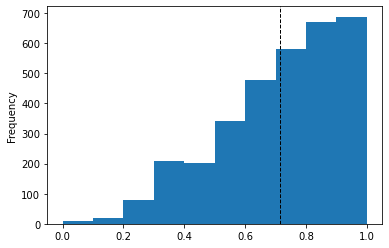

In [35]:
# Make a histogram for the selected resource (ICU Beds or Ventilators)
if hasattr(result, resource_dropdown.value):
    result['icu_beds'].plot.hist(bins=10)
    plt.axvline(result['icu_beds'].mean(), color='k', linestyle='dashed', linewidth=1)
    plt.savefig('./results/figures/reproduction/{}_{}_histogram.png'.format(population_dropdown.value,resource_dropdown.value))
else:
    print(resource_dropdown.value, "not calculated yet.\n")

### Thematic Maps of Accessibility
Compare to figure 7 in the publication.

### Unclassified Accessibility Map

In [36]:
def output_map(output_grid, hospitals, resource):
    ax=output_grid.plot(column=resource, 
                        cmap='PuBuGn',
                        figsize=(18,12), 
                        legend=True, 
                        zorder=1)
    # Next two lines set bounds for our x- and y-axes because it looks like there's a weird 
    # Point at the bottom left of the map that's messing up our frame (Maja)
    ax.set_xlim([325000, 370000])
    ax.set_ylim([550000, 600000])
    hospitals.plot(ax=ax, 
                   markersize=10, 
                   zorder=1, 
                   c='black', 
                   legend=False)

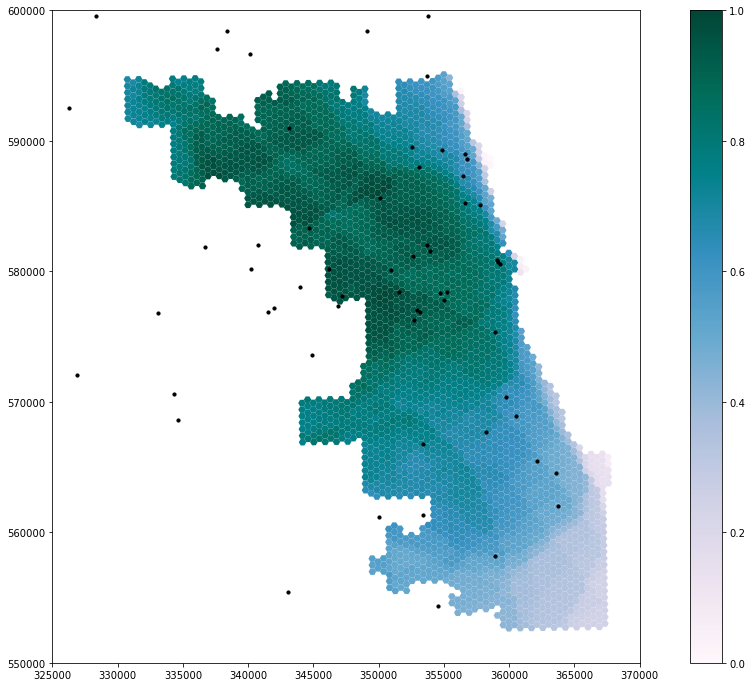

In [37]:
hospitals = hospitals.to_crs({'init': 'epsg:26971'})
result = result.to_crs({'init': 'epsg:26971'})
output_map(result, hospitals, resource_dropdown.value)
# save as image with file name including the resource value, population value, and buffered / not buffered
plt.savefig('./results/figures/reproduction/{}_{}_buff{}_continuous.png'.format(population_dropdown.value, resource_dropdown.value, str(buffered)))

### Classified Accessibility Map

In [38]:
def output_map_classified(output_grid, hospitals, resource):
    ax=output_grid.plot(column=resource, 
                        scheme='Equal_Interval', 
                        k=5, 
                        linewidth=0,
                        cmap='Blues', 
                        figsize=(18,12), 
                        legend=True, 
                        label="Acc Measure",
                        zorder=1)
    # Next two lines set bounds for our x- and y-axes because it looks like there's a weird 
    # Point at the bottom left of the map that's messing up our frame (Maja)
    ax.set_xlim([325000, 370000])
    ax.set_ylim([550000, 600000])
    hospitals.plot(ax=ax, 
                   markersize=10, 
                   zorder=2,
                   c='black',
                   legend=False,
                   )

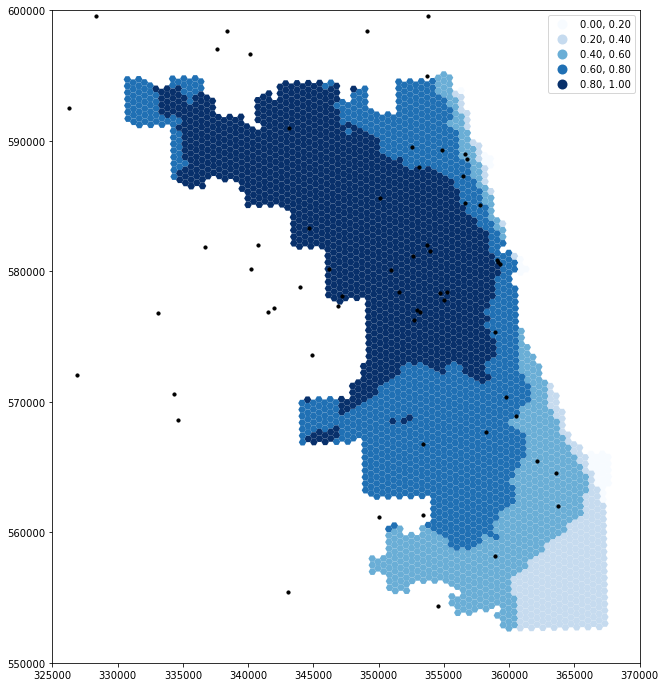

In [39]:
output_map_classified(result, hospitals, resource_dropdown.value)
# save as image with file name including the resource value, population value, and buffered / not buffered
plt.savefig('./results/figures/reproduction/{}_{}_buff{}_classified.png'.format(population_dropdown.value, resource_dropdown.value, str(buffered)))

## Compare Reproduction with Original Results

Load results provided with the original research compendium from shapefile `data/derived/public/Chicago_ACC.shp`. The file contains fields `hospital_i` for "ICU Beds" and `hospital_v` for "Ventilators". It is not known exactly which version of code was used to create this set of results, although it appears that a more complete road network was used (probably the full state of Illinois) than was provided with the compendium (Chicago only, without a buffer). It is not known whether the population was population at risk (>50 years old) or COVID patients (cases). However, the statistical and geographic distributions of each are extremly similar once the data has been normalized.

In [40]:
# Import study results to compare
# hospital_i assumed to be for ICU and hospital_v assumed to be for ventilator
# however it's unknown whether the population is the COVID-19 population or the AT RISK population
fp = 'data/derived/public/Chicago_ACC.shp'
og_result = gpd.read_file(fp)
og_result.set_index("id")
og_result.head()

,id,hospital_i,hospital_v,geometry
0,4158,0.844249,0.843439,"POLYGON ((-87.71312 41.89411, -87.71140 41.896..."
1,4159,0.843600,0.843031,"POLYGON ((-87.71307 41.88961, -87.71135 41.891..."
2,4156,0.906094,0.904699,"POLYGON ((-87.71322 41.90312, -87.71150 41.905..."
3,4157,0.877197,0.876503,"POLYGON ((-87.71317 41.89861, -87.71145 41.900..."
4,4154,0.911424,0.910002,"POLYGON ((-87.71332 41.91212, -87.71160 41.914..."


### Join original results to current results

In [41]:
result.set_index("id")
result_compare = result.join(og_result[["hospital_i","hospital_v"]])
result_compare.head()

,id,area,geometry,icu_beds,hospital_i,hospital_v
0,4158,216661.173,"POLYGON ((351469.371 580527.566, 351609.858 58...",0.917373,0.844249,0.843439
1,4159,216661.168,"POLYGON ((351477.143 580027.445, 351617.630 58...",0.904838,0.843600,0.843031
2,4156,216661.169,"POLYGON ((351453.825 581527.810, 351594.311 58...",0.926078,0.906094,0.904699
3,4157,216661.171,"POLYGON ((351461.598 581027.688, 351602.085 58...",0.909845,0.877197,0.876503
4,4154,216661.171,"POLYGON ((351438.276 582528.054, 351578.761 58...",0.907486,0.911424,0.910002


### Calculate Spearman's Rank Correlation

In [42]:
# set original_resource variable to the name of original results column matching the modeling choice
if resource_dropdown.value == "icu_beds":
    original_resource = "hospital_i"
else:
    original_resource = "hospital_v"

# calculate spearman's rho
rho = stats.spearmanr(result_compare[[original_resource, resource_dropdown.value]])

# format text output
correlationmsg = "Comparing: \n" + "Original resource: " + resource_dropdown.value + " and population: unknown\n" + "Reproduction resource: " + resource_dropdown.value + " and population: " + population_dropdown.value
correlationmsg += "\nStreet network buffered? " + str(buffered)
print(correlationmsg)
rho_result = "Rho = " + str(round(rho.correlation,3)) + ", pvalue = " + str(round(rho.pvalue,3))
print(rho_result)

Comparing: 
Original resource: icu_beds and population: unknown
Reproduction resource: icu_beds and population: covid
Street network buffered? True
Rho = 0.975, pvalue = 0.0


### Create Scatterplot

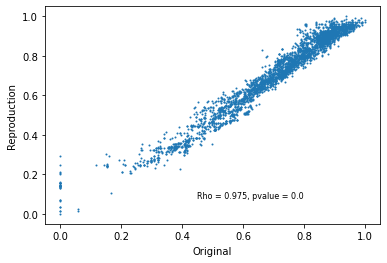

In [43]:
plt.scatter(result_compare[[original_resource]], result_compare[[resource_dropdown.value]], s=1)
plt.xlabel("Original", labelpad=5)
plt.ylabel("Reproduction", labelpad=5)
plt.text(.45, .08, rho_result, fontsize=8)
# save plot as image with file name including icu/ventilators and buffered or not
plt.savefig("./results/figures/reproduction/compare_{}_buffer_{}.png".format(resource_dropdown.value, str(buffered)))

## Conclusions

The reproduction results closely match the orginal results, with a Spearman's *Rho* close to 1 (perfect correlation).
**Here, differentiate correlation results for a buffered network vs not buffered network.**
We can reject the NULL hypothesis of no correlation between the reproduction results and the original results.

However, we also note several challenges and uncertainties.
First, the large file sizes and processing times for the full state of Illinois caused challenges in using GitHub as the repository and scaling the reproduction efforts.
This challenge was addressed by the original research team's decision to limit the reproduction study materials to the city of Chicago.
Unfortunately, that decision led to unanticpated boundary effects and numerous bugs in the code. We have attempted to resolve all of those issues with this reproduction.
Second, the original results were not provided with sufficient metadata to know which permutation of the data and code were used to generate them.
They cannot be identically reproduced with the provided Chicago road network, they do not appear to identically match the maps in the published paper, and we have failed to identically them with a new buffered road network from OpenStreetMap.
The new buffered network produces more similar results, with no discernable difference whether the at risk population (over the age of 50) or the COVID patients (cases) population has been used.

The reproduction effort has identified some additional sources of error and uncertainty which may be addressed with future work.
*First*, there will always be boundary effects with the E2SFCA method, which can only be alleviated by including service points to a distance equal to the maximum travel time away from the study extent, and network data and population data to a distance equal to twice the maximum travel time away from the study extent.
*Second*, there is substaintial missing data in OpenStreetMap speed limits, and the original study has applied speed limits of 35mph to all unknown road segments, even though many are highways and the non-highway urban speed limit in Illinois is 30mph.
*Third*, the study has reaggregated population data to hospital catchments using centroid points, and has re-aggregated catchment areas to the final hexagonal grid if there is 50% or more overlap.
Both reaggregations would be more accurate and less sensitive to the modifiable areal unit problem if they used area-weighted reaggregation.
Finally, there are numerous opportunities to increase the computational efficiency of the code, e.g. by i) reducing redundancies between different versions of the model by processing and storing data before customizing model parameters, ii) reducing by a third the number of network analysis operations, and iii) using GeoPandas spatial indexing to optimize nearest neighbor searching and overlay analysis.

It is difficult to continue reproducing a study like this in updated computational environments because packages like OSMnx have undergone numerous updates, rely on numerous dependencies, and draw data from a dynamic source: OpenStreetMap.
This reproduction study was feasible because the authors developed the research in an open science geospatial cyberinfrastructure community, CyberGISX.
They published the majority of code required to execute the study, and made access to the computational infrastructure available to other researchers.
This enabled the current research team to reproduce the study without building our own cyberinfrastructure, and with minimal or no prior knowledge using Jupyter notebooks or Python.
However, becuase the research was conducted on a shared server, there is no readily available documentation for re-creating a suitable computational environment on a local machine, e.g. through a Conda yaml file.
